### Introduction

This project attempts to identify high growth merchants using unlabeled transaction data. The methodology will use unsupervised learning using k-means clustering and feature engineering. The dataset contains 1 year of merchant transaction data. 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl

%matplotlib inline

### Import Data 

In [2]:
data = pd.read_csv('data.csv', parse_dates=['time'])
data = data.rename(columns={'amount_in_cents': 'cents'})
data['dollars'] = (data['cents'] / 100)
data['month_yr'] = data['time'].apply(lambda x: datetime.datetime(year=x.year, month=x.month, day=1))     
data.head() 

,user,time,cents,dollars,month_yr
0,00038f0484334ac047449166cfbbf6452b31c85c,2016-02-19 23:39:56.925,1203,12.03,2016-02-01
1,00038f0484334ac047449166cfbbf6452b31c85c,2016-02-19 23:41:47.026,1203,12.03,2016-02-01
2,00038f0484334ac047449166cfbbf6452b31c85c,2016-02-23 15:19:54.836,2405,24.05,2016-02-01
3,00038f0484334ac047449166cfbbf6452b31c85c,2016-02-23 15:21:08.273,2405,24.05,2016-02-01
4,00038f0484334ac047449166cfbbf6452b31c85c,2016-02-24 15:19:39.386,1203,12.03,2016-02-01


Create dataframe of monthly transaction amounts to better visualize transaction trajectory over 1-year of users who may be classified as high growth.

In [175]:
# monthly transaction amount by user
monthly_data = data[['user', 'month_yr']].drop_duplicates()
grouped = data['dollars'].groupby([data['user'], data['month_yr']]).sum()
monthly_data['trans_amt'] = grouped.values
count_df = monthly_data.groupby('user')['month_yr'].count().reset_index()
monthly_data = monthly_data.merge(count_df, on=['user'], how='left')

# TODO fix: growth calculation should be grouped by user 
monthly_data['diff'] = monthly_data['trans_amt'] - monthly_data['trans_amt'].shift(-1)
monthly_data.head()

,user,month_yr_x_x,trans_amt,month_yr_y,diff,month_yr_x_y,month_count,ln_trans_amt
0,00038f0484334ac047449166cfbbf6452b31c85c,2016-02-01,350.00,4,-1706.71,2016-02-01,0.0,5.857933
1,00038f0484334ac047449166cfbbf6452b31c85c,2016-03-01,2056.71,4,-5131.37,2016-02-01,29.0,7.628863
2,00038f0484334ac047449166cfbbf6452b31c85c,2016-04-01,7188.08,4,6989.64,2016-02-01,60.0,8.880179
3,00038f0484334ac047449166cfbbf6452b31c85c,2016-05-01,198.44,4,107.04,2016-02-01,90.0,5.290487
4,0012a74e2bb1ab0073b2e18532e87474b6b7cfca,2016-11-01,91.40,1,67.35,2016-11-01,0.0,4.515245


In [153]:
# month transformation: plot by time from user sign-up
init_month = monthly_data['month_yr_x'].groupby(monthly_data['user']).min().reset_index()
monthly_data = monthly_data.merge(init_month, on=['user'], how='left')
monthly_data['month_count'] = monthly_data['month_yr_x_x'] - monthly_data['month_yr_x_y']
monthly_data['month_count'] = monthly_data['month_count'].astype(int)/86400000000000


In [386]:
print len(data)                            # total transactions
print len(data.loc[data['dollars']==0])    # transactions of $0 value
data = data.loc[data['dollars']!=0]
print len(data)                            # transactions without 0 values

1524710
6521
1518189


### Visualizations

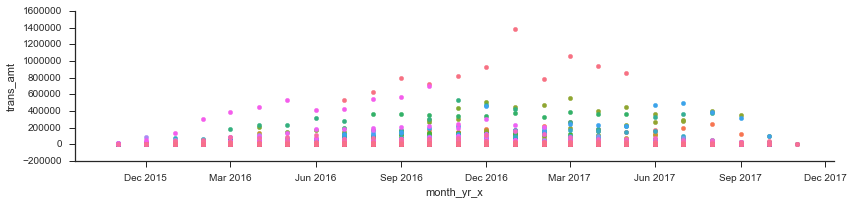

In [385]:
# plotted by month since sign-up, only include users with 12 mon activity

plotting_data = monthly_data.loc[monthly_data['month_yr_y']>11]
sns.set(style='ticks')

# hue_order=_users,  
fg = sns.FacetGrid(data=plotting_data, hue='user', aspect=4)
fg.map(plt.scatter, 'month_yr_x', 'trans_amt').add_legend(); 

Histogram of individual transaction $ amounts.

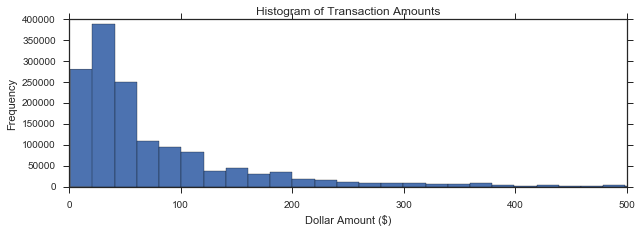

In [182]:
# histogram of transaction amounts
plt.figure(figsize=(10,3))
ax = plt.gca()
plt.hist(data['dollars'], bins=5000)
plt.xlabel('Dollar Amount ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Transaction Amounts')
ax.set_xlim(0, 500)
plt.show();

In [217]:
user_list = user_data['user'].loc[user_data['count'] > 2000]
top_users = user_data.loc[user_data['count'] > 2000]
top_users.head()

Total transaction amount by user. 

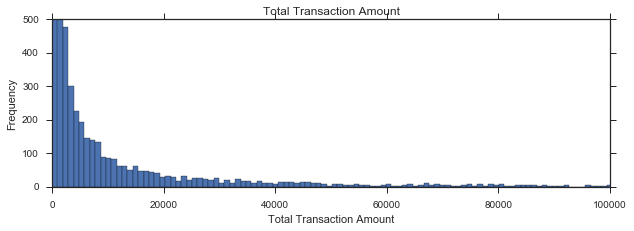

In [228]:
# total transaction amount
plt.figure(figsize=(10,3))
ax = plt.gca()
plt.hist(user_data['tot_trans_amt'], bins=10000)
plt.xlabel('Total Transaction Amount')
plt.ylabel('Frequency')
plt.title('Total Transaction Amount')
ax.set_ylim(0, 500)
ax.set_xlim(0, 100000)
plt.show();

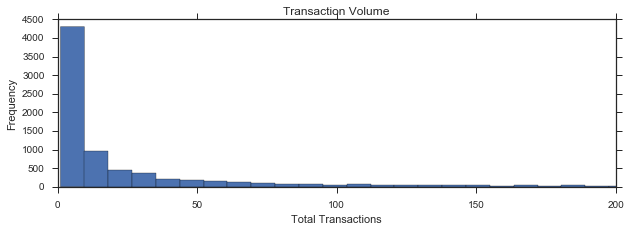

In [224]:
# transaction volume
# most users use app for less than 10 transactions (assign category=1 if also signed up early)
plt.figure(figsize=(10,3))
ax = plt.gca()
plt.hist(user_data['count'], bins=10000)
plt.xlabel('Total Transactions')
plt.ylabel('Frequency')
plt.title('Transaction Volume')
ax.set_xlim(0, 200)
plt.show();

Activity throughout entire year of record is an important indicator of users who are already/may become high priority users. 

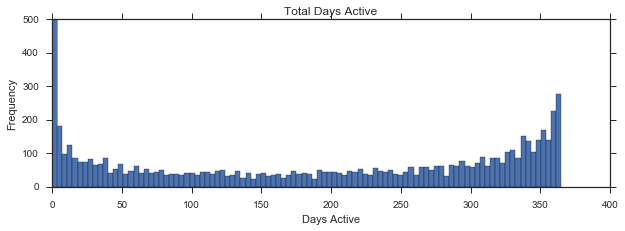

In [223]:
# days active
plt.figure(figsize=(10,3))
ax = plt.gca()
plt.hist(user_data['days_active'], bins=100)
plt.xlabel('Days Active')
plt.ylabel('Frequency')
plt.title('Total Days Active')
ax.set_ylim(0, 500)
plt.show();

### Feature Engineering

Build user-level dataframe including features that may be useful for selecting high growth users for training, such as:

1. Days Active: were they active throughout the entire 1 year period of record
2. Volume of Transactions: differentiate between users with a few transactions and users with ongoing transactions
3. Total Dollar Value of Transactions
4. Growth Indicator: derivative by month of whether or not transaction volume/amount increases or decreases

In [5]:
# create new dataframe on user-level
user_data = pd.DataFrame(data['user'].unique(), columns=['user'])
user_data['count'] = user_data['user'].map(data.groupby('user')['user'].size())
user_data['first_trans_time'] = user_data['user'].map(data.groupby('user')['time'].min())
user_data['last_trans_time'] = user_data['user'].map(data.groupby('user')['time'].max())
user_data['avg_trans_amt'] = user_data['user'].map(data.groupby('user')['dollars'].mean())
user_data['tot_trans_amt'] = user_data['user'].map(data.groupby('user')['dollars'].sum())
user_data['days_active'] = (user_data['last_trans_time'] - user_data['first_trans_time']).dt.days   
# transaction count and amount per day during period of activity... or total?
user_data['trans_per_day'] = (user_data['count'] / user_data['days_active'])
user_data['amt_per_day'] = (user_data['tot_trans_amt'] / user_data['days_active'])
user_data['growth_indicator'] = user_data['user'].map(monthly_data.groupby('user')['diff'].sum())

user_data.head()

,user,count,first_trans_time,last_trans_time,avg_trans_amt,tot_trans_amt,days_active,trans_per_day,amt_per_day,growth_indicator
0,00038f0484334ac047449166cfbbf6452b31c85c,310,2016-02-19 23:39:56.925,2016-05-08 14:38:37.264,31.591065,9793.23,78,3.974359,125.554231,258.60
1,0012a74e2bb1ab0073b2e18532e87474b6b7cfca,2,2016-11-04 14:50:09.257,2016-11-10 00:19:25.407,45.700000,91.40,5,0.400000,18.280000,67.35
2,001855810c25d8bb03210f8c0114de27da9cd76c,195,2016-06-11 15:20:47.121,2017-06-04 19:24:12.293,77.254821,15064.69,358,0.544693,42.080140,-156.35
3,001f3978fa7cad62f2e2ddfa155184a316282b0e,166,2015-11-15 19:57:58.304,2016-11-07 18:17:18.690,166.830361,27693.84,357,0.464986,77.573782,99.82
4,00317873b9dcbcff6759f7ec4225d8531520fdcb,2,2016-02-11 14:09:14.527,2016-02-13 17:00:29.935,40.290000,80.58,2,1.000000,40.290000,-260.96


### Clustering

By inspection, if user:
- has been active less than half a year (given data already segmented by 1-year merchant activity, this implies the merchant has stopped using app before 1-year's end)
- or has performed less than 10 total transactions of <$50 per day (eliminates infrequent users of small transactions)

remove from clustering analysis as these are not high growth merchants. 



In [ ]:
print len(user_data)
print len(user_data.loc[user_data['days_active'] < 185])
print len(user_data.loc[(user_data['count'] < 10) & (user_data['amt_per_day'] < 50)])

cluster_data = user_data.loc[(user_data['days_active'] >= 200)]
# TODO: fix "or" statement to include <$50 per day criteria
cluster_data = cluster_data.loc[(user_data['count'] >= 10)]          
print len(cluster_data)

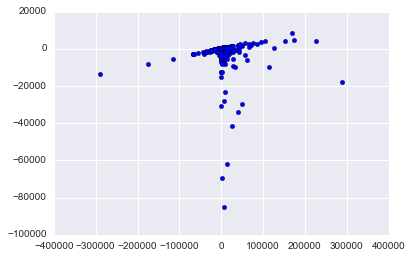

In [7]:
# dimension reduction: visualize in 2d space
pca_data = cluster_data[['days_active', 'count', 'amt_per_day', 'growth_indicator']]
pca = PCA(n_components=2).fit(pca_data)
pca_2d = pca.transform(pca_data)

plt.scatter(pca_2d[:,0], pca_2d[:,1])
plt.show()

In [9]:
cluster_data = cluster_data[['days_active', 'count', 'amt_per_day', 'growth_indicator']]
kmeans = KMeans(n_clusters=3).fit(cluster_data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print centroids

[[ 3.13686858e+02  4.54061602e+02  1.55113586e+02  4.02233556e+02]
 [ 3.01500000e+02  5.15314286e+03  4.30962569e+03  1.30308351e+05]
 [ 2.85333333e+02  5.83333333e+01  9.61017988e+00 -1.92356257e+05]]


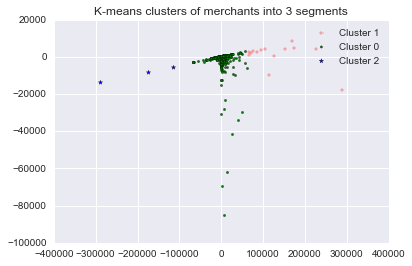

In [12]:
for i in range(0, pca_2d.shape[0]):
    if kmeans.labels_[i] == 1:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif kmeans.labels_[i] == 0:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='.')
    elif kmeans.labels_[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
pl.legend([c1, c2, c3],['Cluster 1', 'Cluster 0','Cluster 2'])
pl.title('K-means clusters of merchants into 3 segments')
pl.show();

In [145]:
# cluster 1 
cluster_data['cluster'] = kmeans.labels_      
cluster_data.loc[cluster_data['cluster'] == 1]

,days_active,count,amt_per_day,growth_indicator,cluster
439,349,3370,6327.482751,175149.26,1
1037,221,4212,9879.563620,126600.16,1
1199,364,32725,2578.830275,289008.64,1
1377,316,5761,8475.119399,226955.74,1
2743,225,622,4072.292000,94796.11,1
3949,253,3129,4502.337708,153869.50,1
4438,346,201,1048.817341,169261.15,1
5589,357,1033,7399.082829,87151.23,1
5974,293,1167,493.360546,106366.21,1
6839,203,14680,6085.194532,113844.03,1


In [192]:
cluster1_index = cluster_data.loc[cluster_data['cluster'] == 1].index
cluster1_data = monthly_data.loc[monthly_data.index.isin(cluster1_index)]
cluster1_data[:10]

cluster1_data.index

Int64Index([439, 1037, 1199, 1377, 2743, 3949, 4438, 5589, 5974, 6839], dtype='int64')

In [197]:
# TODO

# cluster without PCA as well, which reduces algorith's ability to cluster
# visually inspect cluster 1 'high growth' users to ensure features indicate high growth
# test different groupings of features  
# iterate on K clusters (use elbow plot to determine optimal clusters) / can include additional 'high growth' users
# predict: train on half of the dataset and predict on test/validation set
# cross-validation: consider training on user-level (first months of user's data) or transaction-level (portion of transaction data)

### Summary

In my analysis, I have created a handful of features that I believe could be useful in training a model for selecting high priority users, such as days active, volume and amount of transactions, and also a growth indicator. These meaningful features hopefully capture the variability of the data which will be essential for the algorithm to select naturally-occurring groups. My thinking around the growth indicator is that by grouping volume and amount of transactions by a time period (say, month), the derivative for each month period can be calculated and summed up over an entire year. If the sum is greater than zero, then this is an indicator of some degree of growth.

After feature engineering, a k-means clustering analysis was performed on the input data and the selected features to segment (or cluster) high growth merchants from other categories of merchants. Dimensional reduction using PCA was performed to build a 2d representation of the data; however, fitting 2D data reduced by PCA reduces K-means algorithm's ability to cluster the groups correctly since the PCA preprocessing destroys some information. 